# Object Recognition using C.N.N. (CIFAR-10)

The onset of convolutional neural networks brought about a revolution in the way how a computer "understands" images. Computer vision is currently on the bleeding edge of A.I. research, and we have a lot yet to learn. 

In this detailed IPython Notebook, we will train a classifier to recognize whether the image contains a certain object or not.

For this project, I will be using [Google Colab](https://render.githubusercontent.com/https://colab.research.google.com/). For those who are unaware, it is a research project created to disseminate ML education and you can train your neural networks on their Tesla K80 GPUs. It sure speeds up the entire training process. Do check it out.

## 1.  Connect google Drive.

Once connected, we will be able to access the dataset.   

In [37]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## 2. Import Libraries.
Not much to say here...

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

import pickle
import os
import numpy as np
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.models import Sequential #Initialise our neural network model as a sequential network
from keras.layers import Conv2D #Convolution operation
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras.layers import Activation#Applies activation function
from keras.layers import Dropout#Prevents overfitting by randomly converting few outputs to zero
from keras.layers import MaxPooling2D # Maxpooling function
from keras.layers import Flatten # Converting 2D arrays into a 1D linear vector
from keras.layers import Dense # Regular fully connected neural network
from keras import optimizers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard, ModelCheckpoint
from sklearn.metrics import accuracy_score
import keras

from skimage import io
from keras import backend as K
K.set_image_dim_ordering('th')

We will train our neural network on CIFAR-10 (Canadian Institute For Advanced Research) Dataset. This dataset contains 50,000 images which belong to 10 different classes. The following picture will give you a clear idea.

![Dataset Sample](http://parneetk.github.io/images/2017-01-23-cnn-cifar10_files/2017-01-23-cnn-cifar10_8_0.png)

Our neural network will learn how to differentiate between an aeroplane, an automobile, a bird, a cat, a deer, a dog, a frog, a horse, a ship, and a truck. We grown-ups can do this in a fraction of a second but computers are nowhere near to our visual prowess.  

##  3. Define data loading mechanism

The load_data() function will load the dataset into our memory and then prepare it to be used as the train data. Let us have a look at our data. 

  ![Dataset Overview](https://i.imgur.com/qH6ln2O.png)
  
The Dataset consists of five data_batches which contain 10,000 images each and another 10,000 images (32 x 32 pixels) in the test_batch, which as the name suggest, we will use to test our model. The contents of the file are pickled and therefore we will have to un-pickle them before we use them. 

Before we proceed any further, we need to understand how computers understand images. I am going to be a bit verbose, buckle up ;)

For computers everything is numbers. Sequences of zeroes and ones, this is what our computer teachers taught us for eons. Let us step back and observe a bit bigger picture. So, Pictures are nothing but a three-dimensional matrix of numbers. Imagine a 2-D plain, which has 32 columns and 32 rows, this setup will contain 32x32 cells. Each cell stores a number which signifies the intensity of the corresponding pixel. Now, imagine two more such plains and each such plain represents the colours Red, Green, and Blue. Where each cell value depicts the colour intensity at that exact point.

![Image representation](http://www.ansys.stuba.sk/html/prog_55/graphics/AS397.gif)

So when we read the files we get the data stream of numbers which we reshape into a three-dimensional image. We add the image and the label into their respective lists. We do the same for the test batch, which is loaded into the test_data list. We one-hot encode the labels and return all the data in the form of numpy arrays.

In [0]:
def load_data():
  train_data = []
  train_labels = []
  
  for batch_id in range(1, 6):
    if(batch_id == 3): continue
    train_path = "/content/gdrive/My Drive/Colab Notebooks/Object Recognition/Data/" + "data_batch_" + str(batch_id)
    with open(train_path, 'rb') as file:
      Data = pickle.load(file, encoding='latin1')
      data = Data['data'].reshape((len(Data['data']), 3, 32, 32))
      labels = Data['labels']
      train_data.extend(data)
      train_labels.extend(labels)
      
  
  new_train_path = "/content/gdrive/My Drive/Colab Notebooks/Object Recognition/Data/data_batch_3"
  with open(train_path, 'rb') as file:
    Data = pickle.load(file, encoding='latin1')
    data = Data['data'].reshape((len(Data['data']), 3, 32, 32))
    labels = Data['labels']
    train_data.extend(data)
    train_labels.extend(labels)
  
  
  test_data = []
  test_labels = []
  test_path = "/content/gdrive/My Drive/Colab Notebooks/Object Recognition/Data/test_batch"
  with open(test_path, 'rb') as file:
    Data = pickle.load(file, encoding='latin1')
    data = Data['data'].reshape((len(Data['data']), 3, 32, 32))
    labels = Data['labels']
    test_data.extend(data)
    test_labels.extend(labels)
  
  train_labels = np_utils.to_categorical(train_labels)
  test_labels = np_utils.to_categorical(test_labels)
  
  
  print("Size of training data = ", len(train_data))
  print("Size of test data = ", len(test_data))
      
  return np.asarray(train_data), np.asarray(test_data), np.asarray(train_labels), np.asarray(test_labels)

## 4. Load the data.


In [40]:
num_classes = 10
train_data, test_data, train_labels, test_labels = load_data()

Size of training data =  50000
Size of test data =  10000


## 5. Define and Deploy the neural network.

We have built ourselves a Convolutional Neural Network which has convolutional layers armed with filters that extract features out of images.

**So, what's new?**  

In this sequential neural network, I have employed a l2 kernel_regularizer. l2 regularization peanlizes large weigths to prevent overfitting. This penalizes peaky weights and makes sure that all the inputs are considered. During gradient descent parameter update, the above L2 regularization ultimately means that every weight is decayed linearly, that’s why called weight decay.

Callback functions are those functions which are called at the end of every epoch and in this model, we use two callback functions - ReduceLROnPlateau and EarlyStopping. 


> **1. ReduceLROnPlateau:** monitors a certain variable, in this case, validation loss and alters the learning rate when the value stops significantly changing after some certain number of epochs (patience).

> **2. ModelCheckpoin**t: Saves the best version of our model along with the weights, so that in case any crash occurs, our model can be recovered.

We have used Keras to deploy our neural network and if you look at the architecture then you will notice that we have used Dropout layers frequently. Dropout layers inhibit overfitting by randomly dropping out units from the neural network. We will use 20 percent of the training data as validation data.

In [0]:
#######HYPERPARAMATERS###########
epochs = 200
batch_size = 64
learning_rate = 0.001
weight_decay = 0.0005
#################################

model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=l2(weight_decay), input_shape=(3, 32, 32)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
 
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
 
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax'))
 
model.summary()

opt_rms = keras.optimizers.rmsprop(lr=learning_rate, decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3)
checkpointer = ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/Emotion Recognition/Model/weights.hd5', monitor='val_loss', verbose=1, save_best_only=True)

model.fit(
          train_data,
          train_labels,
          epochs = epochs,
          batch_size = batch_size,
          validation_split = 0.2,
          shuffle = True,
          callbacks=[lr_reducer, checkpointer]
          )



## 6. Test the model.

We trained the neural network and we achieved the **highest validation accuracy of 99.93%**. Now, we will use the test data to check how well our model generalizes. 

We score an astounding **accuracy of 86.21% on the test set**. Did you notice the massive difference between the validation accuracy and test accuracy? It occured because after a certain number of epochs, our model started overfitting and when we brought in a previously unseen batch of data(test_data) our model didn't perform that well. Though 86.21 is a fine score, there is a lot of scope for improvement.

In [42]:
predicted_test_labels = np.argmax(model.predict(test_data), axis=1)
#test_labels = np.argmax(test_labels, axis=1)
print ("Accuracy score = ", accuracy_score(test_labels, predicted_test_labels))

Accuracy score =  0.8621


## 7. Save the model.

In [56]:
from keras.models import model_from_json
model_json = model.to_json()
with open("/content/gdrive/My Drive/Colab Notebooks/Object Recognition/Model/model-9993.json", "w") as json_file:
    json_file.write(model_json)
 # serialize weights to HDF5
model.save_weights("/content/gdrive/My Drive/Colab Notebooks/Object Recognition/Model/model-9993.h5")
print("Saved model to disk")

Saved model to disk


## 8. Analysis.

We are done training and testing our model and got a decent accuracy on the test set as well but it cannot be the sole criteria to judge our model. Now, its time to analyze and we will start off by printing a confusion matrix.


### Confusion Matrix
Confused about the confusion matrix? Confusion matrix gives us a clear insight into the errors our model is making and what all is it getting right.

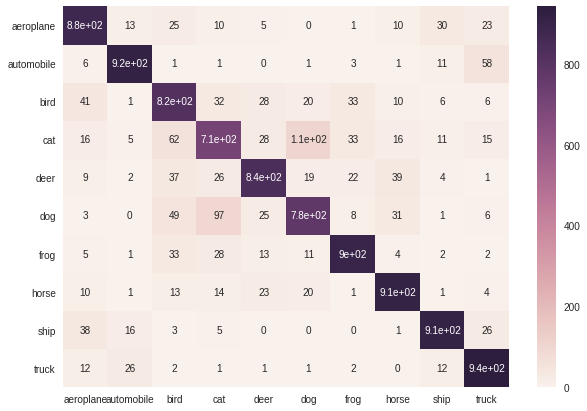

In [43]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd


label_names = ['aeroplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
cm = confusion_matrix(test_labels, predicted_test_labels)
df_cm = pd.DataFrame(cm, index = [obj for obj in label_names],
                  columns = [obj for obj in label_names])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

We use _seaborn_ to plot our confusion matrix to make the analysis easier. The y-axis depicts predicted labels while the actual labels are on the x-axis.
Let us take the first cell (Top-left) into consideration, this cell represents the number of images which were accurately classified as an aeroplane. Similarly, the forward diagonal represents other correct predictions.

41 birds were misclassified as aeroplanes while no automobile was classified as a deer. Notice how a lot of cats are misclassified as dogs, that number is huge. This means that our model did not learn the features of a cat well enough. Trying out a different arrangement of layers may help fix this issue.    

## Notes

Higher accuracies can be obtained by:  
  - **Changing the network architecture**.
  - **Using Data augmentation**: which is the process of randomly changing the images without interfearing with their interpretations. The images can be zoomed, flipped ,and rotated. For e.g., an image of a plane which is rotated and zoomed will still show a plane and this won't affect the interpretation.
  
I will be updating this Notebook in the near future, using better techniques as I gain further understanding of the concepts.